In [1]:
%load_ext jbmagics
old_path = %env PATH
%env PATH = $old_path:/Users/mike/hydrocomputing/projects/2021/003_ModSimple_Phase2/Bearbeitung/MODFLOW6/mf6.4.1/bin
%env DLL_PATH = /Users/mike/hydrocomputing/projects/2021/003_ModSimple_Phase2/Bearbeitung/MODFLOW6/mf6.4.1/bin/libmf6.dylib

Exception reporting mode: Minimal
env: PATH=/Users/mike/.rvm/gems/ruby-3.0.0@latest/bin:/Users/mike/.rvm/gems/ruby-3.0.0@global/bin:/Users/mike/.rvm/rubies/ruby-3.0.0/bin:/Users/mike/miniconda3/envs/pymf6_py311_m1/bin:/Users/mike/miniconda3/condabin:/Library/Frameworks/Python.framework/Versions/3.9/bin:/Users/mike/.nimble/bin:/Users/mike/.cargo/bin:/Users/mike/pya/Konferenzen/EuroPython/EuroPython2019/taken_trainings/k8s-101-python-developers/google-cloud-sdk/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Users/mike/bin:/Users/mike/Dev/tools:/Users/mike/.local/bin:/Applications/Racket v7.3/bin:/Users/mike/.rvm/bin:/Users/mike/hydrocomputing/projects/2021/003_ModSimple_Phase2/Bearbeitung/MODFLOW6/mf6.4.1/bin
env: DLL_PATH=/Users/mike/hydrocomputing/projects/2021/003_ModSimple_Phase2/Bearbeitung/MODFLOW6/mf6.4.1/bin/libmf6.dylib


# Example: Head Controlled Well

This example demonstrates how `pymf6` can be used to control the rate of an
extraction well so that the well water level does fall below under a given water
level.

## Setting up a model with `flopy`

First, we create a simple model with `flopy`.
You may use any GUI tool such as ModelMuse to create such a model.
This is not specific to `pymf6` but helps to better understand the problem.
You may skip ahead to the section with use of `pymf6`.

### Creating the input data

First, we import a few need libraries:

In [2]:
%%include make_model.py
end_at = 'import numpy'
import_module = True

```python
"""Create, run, and postprocess a MODFLOW 6 model with flopy.
"""

import flopy
from flopy.utils.postprocessing import get_specific_discharge
from matplotlib import pyplot as plt
import numpy as np
```


The function `make_input` creates our model with help pf `flopy`:

In [3]:
%%include make_model.py
start_at = 'def _make_wel_stress_period'
end_at = 'sim.write_simulation()'
import_module = True

```python
def _make_wel_stress_period(gwf, wel_q, wel_coords):
    """Create stress period data for the wel package."""
    period = flopy.mf6.ModflowGwfwel.stress_period_data.empty(
        gwf,
        maxbound=1,
    )
    period[0][0] = (wel_coords, wel_q)
    return period


def make_input(
    wel_q,
    wel_coords,
    model_path,
    name,
    exe_name='mf6',
    verbosity_level=0):
    """Create MODFLOW 6 input"""
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=model_path,
        exe_name=exe_name,
        verbosity_level=verbosity_level,
    )
    times = (10.0, 120, 1.0)
    tdis_rc = [(1.0, 1, 1.0), times, times, times]
    flopy.mf6.ModflowTdis(
        sim, pname="tdis",
        time_units="DAYS",
        nper=4,
        perioddata=tdis_rc,
    )
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(gwf, nrow=10, ncol=10)
    flopy.mf6.ModflowGwfic(gwf)
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_specific_discharge=True,
        icelltype=[0],
        k=[0.5],
        k33=[0.1],
    )
    sy = flopy.mf6.ModflowGwfsto.sy.empty(
        gwf,
        default_value=0.2
    )
    ss = flopy.mf6.ModflowGwfsto.ss.empty(
        gwf, default_value=0.000001
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        pname="sto",
        save_flows=True,
        save_specific_discharge=True,
        iconvert=1,
        ss=ss,
        sy=sy,
        transient={0: True},
        )

    stress_period_data = {
        1: _make_wel_stress_period(gwf, wel_q / 10, wel_coords)[0],
        2: _make_wel_stress_period(gwf, wel_q, wel_coords)[0],
        3: _make_wel_stress_period(gwf, wel_q / 10, wel_coords)[0]
    }
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=stress_period_data,
    )
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=[
            [(0, 0, 0), 1.],
            [(0, 9, 9), 1.]],
    )
    budget_file = name + '.bud'
    head_file = name + '.hds'
    flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
    sim.write_simulation()
```


We specify some data for the model:

In [4]:
model_path=r'models\mf6'
name='headconwell'
wel_coords=(0, 4, 4)
wel_q = -0.5

and create the input files.

In [5]:
make_input(
    wel_q=wel_q,
    wel_coords=wel_coords,
    model_path=model_path,
    name=name
)

### Running the model

The function `get_simulation` retrieves a `flopy` simulation object:

In [6]:
%%include make_model.py
start_at = 'def get_simulation'
end_at = 'return'
import_module = True

```python
def get_simulation(model_path, exe_name='mf6', verbosity_level=0):
    """Get simulation for a model."""
    sim = flopy.mf6.MFSimulation.load(
        sim_ws=model_path,
        exe_name=exe_name,
        verbosity_level=verbosity_level,
    )
    return sim
```


This function runs the model:

In [7]:
%%include make_model.py
start_at = 'def run_simulation'
end_at = 'sim.run_simulation()'
import_module = True

```python
def run_simulation(model_path, verbosity_level=0):
    """Run a MODFLOW 6 model"""
    sim = get_simulation(
        model_path,
        verbosity_level=verbosity_level)
    sim.run_simulation()
```


We run the simulation:

In [8]:
run_simulation(model_path=model_path)

There is visible output from MODFLOW 6.
Setting the `verbosity_level` to `1` or higher in `run_simulation` will show
the simulations steps.

### Looking at the model results

Let's look at the model results.
This function visualizes the head at the end of the last time step: 

In [9]:
%%include make_model.py
start_at = 'def show_head'
end_at = 'pmv.plot_vector'
import_module = True

```python
def show_heads(model_path, name):
    """Plot calculated heads along with flow vector."""
    sim = get_simulation(model_path, name)
    gwf = sim.get_model(name)

    head = gwf.output.head().get_data()
    bud = gwf.output.budget()

    spdis = bud.get_data(text='DATA-SPDIS')[-1]
    qx, qy, _ = get_specific_discharge(spdis, gwf)
    pmv = flopy.plot.PlotMapView(gwf)
    pmv.plot_array(head)
    pmv.plot_grid(colors='white')
    pmv.contour_array(
        head,
        levels=np.arange(0.2, 1.0, 0.02),
    )
    plot = pmv.plot_vector(
        qx,
        qy,
        normalize=True,
        color="white")
    plot.axes.set_xlabel('X [m]')
    plot.axes.set_ylabel('Y [m]')
    plot.axes.set_title('Head-Controlled Well')
    cbar = plot.get_figure().colorbar(plot)
    cbar.set_label('Water level [m]')
    return plot


def show_well_head(model_path, name, wel_coords):
    """Plot head at well over time."""
    sim = get_simulation(model_path, name)
    gwf = sim.get_model(name)
    heads = gwf.output.head().get_ts(wel_coords)
    _, ax = plt.subplots()
    ax.plot(heads[:, 0], heads[:, 1], label='Well water level')
    ax.set_xlabel('Time [d]')
    ax.set_ylabel('Water level [m]')
    y_start = 0.3
    y_end = 1.05
    y_stress = (y_start, y_end)
    x_stress_1 = (1, 1)
    x_stress_2 = (11, 11)
    x_stress_3 = (21, 21)
    tolerance = 0.01
    head_limit = 0.5
    x = [0, 32]
    ax.set_xlim(*x)
    ax.set_ylim(y_start, y_end)
    y1 = [head_limit - tolerance, head_limit - tolerance]
    y2 = [head_limit + tolerance, head_limit + tolerance]
    ax.plot(x, y1, color='red', linestyle=':', label='Target water level range')
    ax.plot(x, y2, color='red', linestyle=':')
    ax.plot(
         x_stress_1, y_stress,
         color='lightblue', linestyle=':', label='Stress periods')
    ax.plot(
         x_stress_2, y_stress,
         x_stress_3, y_stress,
         color='lightblue', linestyle=':')
    ax.legend(loc=(1.1, 0))
    return ax


def do_all(model_path, name, wel_q=0, verbosity_level=0):
    """Do all steps:

    * create model input files
    * run the simulation
    * show calculated heads as map
    * show head at well over time
    """
    wel_coords = (0, 4, 4)
    make_input(
        wel_q=wel_q,
        wel_coords=wel_coords,
        model_path=model_path,
        name=name,
        verbosity_level=verbosity_level
        )
    run_simulation(
        model_path=model_path,
        verbosity_level=verbosity_level
        )
    show_heads(model_path, name)
    show_well_head(model_path, name, wel_coords)
```


We look at the heads:

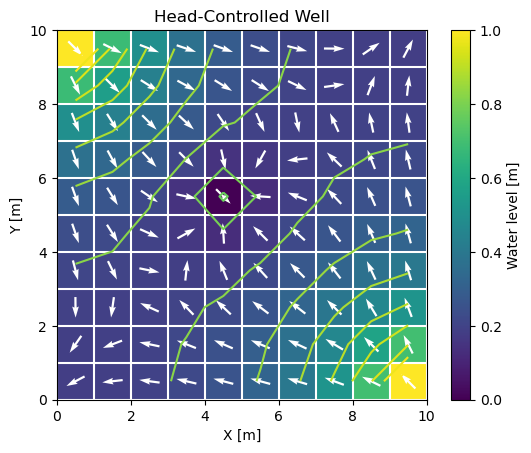

In [21]:
show_heads(model_path=model_path, name=name);

The well is roughly in the middle of the model.
The yellow cells have a constant water level and "feed" the model.
The well causes a cone of depression.

This function shows the head the well location over time:

In [11]:
%%include make_model.py
start_at = 'def show_well_head'
end_at = 'return'
import_module = True

```python
def show_well_head(model_path, name, wel_coords):
    """Plot head at well over time."""
    sim = get_simulation(model_path, name)
    gwf = sim.get_model(name)
    heads = gwf.output.head().get_ts(wel_coords)
    _, ax = plt.subplots()
    ax.plot(heads[:, 0], heads[:, 1], label='Well water level')
    ax.set_xlabel('Time [d]')
    ax.set_ylabel('Water level [m]')
    y_start = 0.3
    y_end = 1.05
    y_stress = (y_start, y_end)
    x_stress_1 = (1, 1)
    x_stress_2 = (11, 11)
    x_stress_3 = (21, 21)
    tolerance = 0.01
    head_limit = 0.5
    x = [0, 32]
    ax.set_xlim(*x)
    ax.set_ylim(y_start, y_end)
    y1 = [head_limit - tolerance, head_limit - tolerance]
    y2 = [head_limit + tolerance, head_limit + tolerance]
    ax.plot(x, y1, color='red', linestyle=':', label='Target water level range')
    ax.plot(x, y2, color='red', linestyle=':')
    ax.plot(
         x_stress_1, y_stress,
         color='lightblue', linestyle=':', label='Stress periods')
    ax.plot(
         x_stress_2, y_stress,
         x_stress_3, y_stress,
         color='lightblue', linestyle=':')
    ax.legend(loc=(1.1, 0))
    return ax
```


This is the head at the well over time:

<Axes: xlabel='Time [d]', ylabel='Water level [m]'>

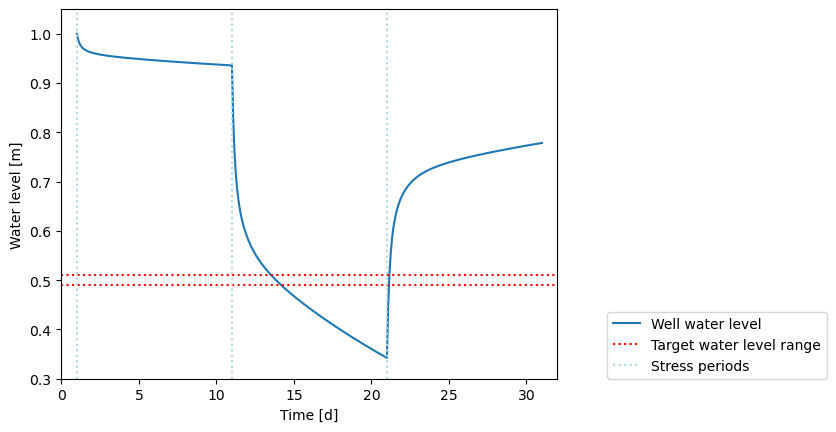

In [13]:
show_well_head(model_path=model_path, name=name, wel_coords=wel_coords);

There are four stress periods.
The first period is steady state.
Periods two to four a transient with different extraction rate.
Period three has the full rate and periods two and four have only a tenth of the
rate. See generation of the input files for details.

## Working with `pymf6`

Finally, we will use `pymf6`.
The objective is the avoid a drop of the water level at the well below a given 
limit.

### Creating new input files

We generate the input files again.
There are no differences in the files to the model above.
The only difference is the model directory:

In [14]:
model_path=r'models\pymf6'

Creating the input files:

In [15]:
make_input(
    wel_q=wel_q,
    wel_coords=wel_coords,
    model_path=model_path,
    name=name
)

### Run the model with `pymf6`

Now run the model with `pymf6`:

In [16]:
%%include pymf6_head_controlled_well.py
end_before = 'if __name__ =='
import_module = True

```python
from pymf6.mf6 import MF6

def run_model(nam_file):
    mf6 = MF6(nam_file=nam_file)
    head = mf6.vars['SLN_1/X']
    wel_index = 44
    tolerance = 0.01
    head_limit = 0.5
    upper_limit = head_limit + tolerance
    lower_limit = head_limit - tolerance
    wel = mf6.vars['HEADCONWELL/WEL_0/BOUND']
    been_below = False
    for step in mf6.steps():
        if step < 21:
            if head[wel_index] <= upper_limit:
                wel[:] = wel[:] * 0.9
                been_below = True
            elif been_below and head[wel_index] >= upper_limit:
                wel[:] = wel[:] * 1.1
```


The class `MF6` provides the functionality of `pymf6`.
The dictionary `mf6.vars` provides all MODFLOW 6 variables.
The head has the name `SLN_1/X` and the values of the boundary condition `WEL`
is `HEADCONWELL/WEL_0/BOUND`.
The name will change depending on model name and the chosen name for the
boundary condition.

`mf6.steps()` provides a generator that allows to iterate over all MODFLOW 6 
time steps.
`step` is the current time step in the unit specified in the input files, here
`DAYS`.
We don't want influence the last, which starts at day 21.
We adjust the extraction rate by reducing o increasing the rate by 10%,
if the water level at the well, found at index 44, is not within the upper
and lower limit.

Running the model:

In [17]:
run_model(r'models/pymf6/mfsim.nam')

### Looking at the results

Now the water level stays just around 0.5:

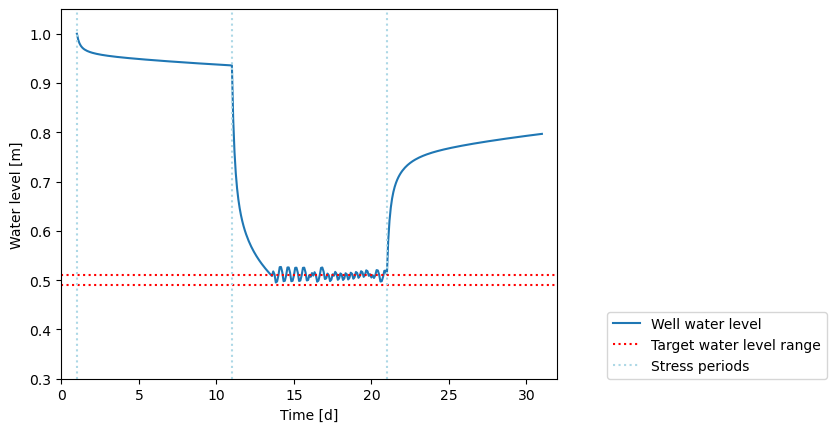

In [20]:
show_well_head(model_path=model_path, name=name, wel_coords=wel_coords);

There is some oscillation in the water level.
These can be reduced by adding more time steps in the TDIS package.